# Black–Litterman + Ledoit–Wolf (Monthly, 2015–2024)
- 30-ETF multi-asset universe; monthly end-of-month simple returns.
- Risk: 36-month Ledoit–Wolf covariance (annualized).  
- BL: τ=0.05, λ=3.0, confidence c=0.6; views = sector-neutral 12–1 momentum + dividend carry (z-scored).
- Optimization (monthly): maximize μᵀw − λ_r wᵀΣw − γ‖w−w_prev‖₁  
  s.t. sum=1; long-only + sector caps (±15%) + 12% vol target (BL/EQ).
  MVO is unconstrained (budget only).

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.covariance import LedoitWolf
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# Universe (30 ETFs)
TICKERS = [
    "SPY","QQQ","IWM","EFA","EEM","VTV","VUG","IWD","IWF","XLV","XLF","XLY","XLP",
    "XLI","XLE","XLU","XLB","XLRE",  # 18 equities
    "SHY","IEF","TLT",               # rates (3)
    "TIP",                           # TIPS (1)
    "VNQ",                           # REITs (1)
    "DBC","GLD","SLV","USO","DBA",   # commodities (5)
    "HYG","LQD",                     # HY/IG credit (2)
]

SECTORS = {
    "Equities": ["SPY","QQQ","IWM","EFA","EEM","VTV","VUG","IWD","IWF","XLV","XLF","XLY","XLP","XLI","XLE","XLU","XLB","XLRE"],
    "Treasuries": ["SHY","IEF","TLT"],
    "TIPS": ["TIP"],
    "REITs": ["VNQ"],
    "Commodities": ["DBC","GLD","SLV","USO","DBA"],
    "IG": ["LQD"],
    "HY": ["HYG"],
}

## Benchmark & Parameters
- Benchmark: 60% Equities, 30% Bonds (Treasuries + TIPS + IG + HY), 10% Real Assets (Commodities + REITs), pro-rated within groups.
- Main parameters for BL, optimization, and costs.

In [3]:
def make_benchmark(tickers, sectors):
    b = pd.Series(0.0, index=tickers, dtype=float)
    eq = sectors["Equities"]; b[eq] = 0.60 / len(eq)
    bond_members = sectors["Treasuries"] + sectors["TIPS"] + sectors["IG"] + sectors["HY"]
    b[bond_members] = 0.30 / len(bond_members)
    ra_members = sectors["Commodities"] + sectors["REITs"]
    b[ra_members] = 0.10 / len(ra_members)
    return b

B_BENCH = make_benchmark(TICKERS, SECTORS)
SECTOR_TARGETS = {
    "Equities": B_BENCH[SECTORS["Equities"]].sum(),
    "Treasuries": B_BENCH[SECTORS["Treasuries"]].sum(),
    "TIPS": B_BENCH[SECTORS["TIPS"]].sum(),
    "IG": B_BENCH[SECTORS["IG"]].sum(),
    "HY": B_BENCH[SECTORS["HY"]].sum(),
    "Commodities": B_BENCH[SECTORS["Commodities"]].sum(),
    "REITs": B_BENCH[SECTORS["REITs"]].sum(),
}

START_ALL = "2004-01-01"
BT_START  = "2015-01-31"
BT_END    = "2024-12-31"
LOOKBACK  = 36
TAU       = 0.05
LAMBDA_EQ = 3.0
K_TILT    = 0.02
CONF_MAIN = 0.6
LAMBDA_RISK = 5.0
GAMMA_L1    = 0.005
VOL_TARGET  = 0.12
COST_PER_TURNOVER = 0.001

In [4]:
def load_monthly_data(tickers):
    df = yf.download(
        tickers, start=START_ALL, end=BT_END, auto_adjust=False,
        progress=False, actions=True, group_by="ticker",
    )
    adj, divm = {}, {}
    for t in tickers:
        if isinstance(df.columns, pd.MultiIndex):
            px = df[t]["Adj Close"].dropna()
            dv = df[t]["Dividends"].fillna(0.0)
        else:
            px = df["Adj Close"].dropna()
            dv = df["Dividends"].fillna(0.0)
        adj[t]  = px.resample("ME").last()
        divm[t] = dv.resample("ME").sum()
    prices = pd.DataFrame(adj).dropna(how="all")
    divs   = pd.DataFrame(divm).reindex_like(prices).fillna(0.0)
    first_valid = prices.apply(lambda s: s.first_valid_index())
    start_all   = max(first_valid.dropna())
    prices = prices.loc[start_all:]
    divs   = divs.loc[prices.index]
    prices = prices.dropna(axis=0, how="any")
    divs   = divs.loc[prices.index]
    return prices, divs


## Signals (Momentum 12–1 & Carry), Neutralization, Z-scores
- Momentum: product of returns from t−12..t−2 (skip t−1).  
- Carry: trailing 12m dividends divided by current price.  
- Neutralize within **coarse cap groups** each month; then cross-sectional z-score.

In [5]:
def compute_signals(prices, divs, sectors):
    rets = prices.pct_change()
    mom  = (1.0 + rets.shift(2)).rolling(11).apply(np.prod, raw=True) - 1.0
    div12 = divs.rolling(12).sum()
    carry = div12 / prices

    # sector-neutralization uses the coarse cap groups; singleton sleeves (TIP, LQD, HYG, VNQ) get 0 direct tilt
    def neutralize(df):
        out = df.copy()
        for dt in df.index:
            row = df.loc[dt]
            for _, members in sectors.items():
                idx = [m for m in members if m in row.index]
                if len(idx) > 0:
                    out.loc[dt, idx] = row[idx] - row[idx].mean()
        return out

    mom_n   = neutralize(mom)
    carry_n = neutralize(carry)

    def zscore(df):
        mu = df.mean(axis=1); sd = df.std(axis=1, ddof=0).replace(0, np.nan)
        z  = (df.sub(mu, axis=0)).div(sd, axis=0)
        return z.fillna(0.0)

    z_mom = zscore(mom_n)
    z_car = zscore(carry_n)
    z     = 0.5 * z_mom + 0.5 * z_car
    z_fin = zscore(z)
    return rets, z_fin


In [6]:
def ledoit_wolf_cov(ret_win):
    lw = LedoitWolf(store_precision=False, assume_centered=False)
    lw.fit(ret_win.values)
    Sigma_m = pd.DataFrame(lw.covariance_, index=ret_win.columns, columns=ret_win.columns)
    return Sigma_m * 12.0

def sample_cov(ret_win):
    X = ret_win.values
    S = np.cov(X, rowvar=False, ddof=1)
    return pd.DataFrame(S, index=ret_win.columns, columns=ret_win.columns) * 12.0

def robust_inv(A, eps=1e-8):
    n = A.shape[0]
    return np.linalg.inv(A + eps * np.eye(n))


In [7]:
def bl_posterior(Sigma_ann, b, z_t, tau=TAU, lam=LAMBDA_EQ, k=K_TILT, c=CONF_MAIN):
    
    # clip confidence for stable omega
    c = float(np.clip(c, 1e-6, 1.0 - 1e-6))
    
    pi = lam * (Sigma_ann @ b.values)
    Q  = pi + k * z_t.values
    diag_tauS  = np.diag((tau * Sigma_ann).values)
    omega_diag = ((1 - c) / c) * np.maximum(diag_tauS, 1e-10)
    tauS_inv   = robust_inv(tau * Sigma_ann.values, eps=1e-10)
    omega_inv  = np.diag(1.0 / omega_diag)
    A   = tauS_inv + omega_inv
    rhs = tauS_inv @ pi + omega_inv @ Q
    mu_bl    = robust_inv(A, eps=1e-10) @ rhs
    Sigma_bl = Sigma_ann.values + robust_inv(A, eps=1e-10)
    mu_bl    = pd.Series(mu_bl, index=Sigma_ann.index)
    Sigma_bl = pd.DataFrame(Sigma_bl, index=Sigma_ann.index, columns=Sigma_ann.columns)
    return mu_bl, Sigma_bl, pd.Series(pi, index=Sigma_ann.index)


## Constraints & Solver
- Sector caps use the benchmark sector totals ±15%.
- BL/EQ: long-only, sector caps, **12% annualized vol cap**, **variance regularization** (λ_r · w'Σw), and **L1 turnover penalty** to the previous weights.
- MVO baseline: **budget-only** (1'w = 1); **no vol cap**, **no variance penalty**, **no turnover penalty**.
- Ex-post scaling: if BL/EQ exceed the 12% vol target after solving, blend toward the benchmark to hit the cap.
- Optimization objective:
  - BL/EQ: maximize μ' w − λ_r·w'Σw − γ‖w − w_prev‖₁ subject to the above constraints.
  - MVO: maximize μ' w subject only to 1'w = 1.

In [8]:
def sector_caps_constraints(w, tickers, sector_targets, band=0.15):
    cons = []
    for g, target in sector_targets.items():
        members = SECTORS[g]
        idx = [tickers.index(m) for m in members if m in tickers]
        if len(idx) == 0: 
            continue
        w_sum = cp.sum(cp.hstack([w[i] for i in idx]))
        lo = max(0.0, target - band)
        hi = min(1.0, target + band)
        cons += [w_sum >= lo, w_sum <= hi]
    return cons

def scale_to_vol(w, b, Sigma, vol_target, tol=1e-6, iters=30):
    w = np.asarray(w); b = np.asarray(b)
    def ann_vol(x): return float(np.sqrt(x @ Sigma.values @ x))
    v = ann_vol(w)
    if v <= vol_target + tol: 
        return w
    lo, hi = 0.0, 1.0
    for _ in range(iters):
        mid = 0.5 * (lo + hi)
        x   = mid * w + (1 - mid) * b
        if ann_vol(x) > vol_target: hi = mid
        else: lo = mid
    return lo * w + (1 - lo) * b

def solve_portfolio(mu, Sigma, w_prev, b_vec, strategy="BL", 
                    vol_cap=VOL_TARGET, gamma=GAMMA_L1, lam_r=LAMBDA_RISK):
    n = len(mu); w = cp.Variable(n)
    Sigma_num = Sigma.values + 1e-10 * np.eye(n)
    quad = cp.quad_form(w, Sigma_num)
    obj  = mu.values @ w - lam_r * quad
    # obj = mu.values @ w
    # if strategy in ("BL", "EQ") and (lam_r is not None) and (lam_r > 0):
    #     obj -= lam_r * quad

    cons = [cp.sum(w) == 1.0]
    if strategy in ("BL", "EQ"):
        cons += [w >= 0]
        cons += sector_caps_constraints(w, list(mu.index), SECTOR_TARGETS, band=0.15)
        cons += [quad <= vol_cap**2]
        if w_prev is None: 
            w_prev = np.array([1.0 / n] * n)
        obj = obj - gamma * cp.norm1(w - w_prev)
    prob = cp.Problem(cp.Maximize(obj), cons)
    try:
        prob.solve(solver=cp.ECOS, verbose=False, abstol=1e-8, reltol=1e-8, feastol=1e-8)
    except Exception:
        prob.solve(solver=cp.SCS,  verbose=False, eps=1e-4, max_iters=5000)
    sol = np.array(w.value).flatten() if w.value is not None else np.full(n, 1.0 / n)
    if strategy in ("BL", "EQ"):
        current_vol = float(np.sqrt(sol @ Sigma.values @ sol))
        if current_vol > vol_cap + 1e-6:
            sol = scale_to_vol(sol, b_vec.values, Sigma, vol_cap)
    return sol, prob.status


## Backtest (walk-forward, monthly rebalances)
- Strict 36-month lookback.  
- Turnover measured vs previous strategy weights; **MVO’s first trade is charged vs benchmark**.

In [9]:
def backtest(prices, divs, zsig, b_bench, start_date=BT_START, end_date=BT_END):
    prices = prices.loc[:end_date]
    rets_full = prices.pct_change().dropna()
    zsig = zsig.loc[rets_full.index]
    all_dates = rets_full.index
    start_dt, end_dt = pd.to_datetime(start_date), pd.to_datetime(end_date)
    start_idx, end_idx = LOOKBACK - 1, len(all_dates) - 2
    idxs = [i for i in range(start_idx, end_idx + 1) if (all_dates[i] >= start_dt) and (all_dates[i] <= end_dt)]

    tickers = list(rets_full.columns); n = len(tickers)
    w_prev_bl  = b_bench.loc[tickers].values.copy()
    w_prev_eq  = b_bench.loc[tickers].values.copy()
    w_prev_mvo = b_bench.loc[tickers].values.copy()

    W_BL, W_MVO, W_EQ = [], [], []
    R_BL, R_MVO, R_EQ = [], [], []
    TO_BL, TO_MVO, TO_EQ = [], [], []
    solver_status = {"BL": [], "EQ": [], "MVO": []}

    for i in idxs:
        dt, next_dt = all_dates[i], all_dates[i + 1]
        win = rets_full.loc[all_dates[i - LOOKBACK + 1] : all_dates[i]]
        if len(win) < LOOKBACK: 
            continue

        Sigma = ledoit_wolf_cov(win)

        mu_bl, Sigma_bl, pi = bl_posterior(Sigma, b_bench.loc[tickers], zsig.loc[dt],
                                           tau=TAU, lam=LAMBDA_EQ, k=K_TILT, c=CONF_MAIN)

        w_bl, st_bl  = solve_portfolio(mu_bl.loc[tickers], Sigma_bl.loc[tickers, tickers],
                                        w_prev_bl, b_bench.loc[tickers], strategy="BL")
        w_mvo,st_mvo = solve_portfolio(mu_bl.loc[tickers], Sigma.loc[tickers, tickers],
                                        w_prev=None, b_vec=b_bench.loc[tickers], strategy="MVO", gamma=0)
        w_eq, st_eq  = solve_portfolio(pd.Series(pi, index=tickers), Sigma.loc[tickers, tickers],
                                        w_prev_eq, b_bench.loc[tickers], strategy="EQ")

        def sector_sums(w):
            sums = {}
            for g, members in SECTORS.items():
                idxm = [tickers.index(m) for m in members if m in tickers]
                sums[g] = float(np.sum(w[idxm])) if len(idxm) > 0 else 0.0
            return sums

        ss_bl, ss_eq = sector_sums(w_bl), sector_sums(w_eq)
        for g, target in SECTOR_TARGETS.items():
            lo = max(0.0, target - 0.15) - 1e-8
            hi = min(1.0, target + 0.15) + 1e-8
            assert (ss_bl[g] >= lo - 1e-8) and (ss_bl[g] <= hi + 1e-8)
            assert (ss_eq[g] >= lo - 1e-8) and (ss_eq[g] <= hi + 1e-8)

        r_next = rets_full.loc[next_dt].values
        to_bl  = 0.5 * np.sum(np.abs(w_bl  - w_prev_bl))
        to_mvo = 0.5 * np.sum(np.abs(w_mvo - w_prev_mvo))
        to_eq  = 0.5 * np.sum(np.abs(w_eq  - w_prev_eq))
        cost_bl  = COST_PER_TURNOVER * to_bl
        cost_mvo = COST_PER_TURNOVER * to_mvo
        cost_eq  = COST_PER_TURNOVER * to_eq

        R_BL.append(float(np.dot(w_bl,  r_next) - cost_bl))
        R_MVO.append(float(np.dot(w_mvo, r_next) - cost_mvo))
        R_EQ.append(float(np.dot(w_eq,  r_next) - cost_eq))
        W_BL.append(w_bl); W_MVO.append(w_mvo); W_EQ.append(w_eq)
        TO_BL.append(to_bl); TO_MVO.append(to_mvo); TO_EQ.append(to_eq)
        solver_status["BL"].append(st_bl); solver_status["MVO"].append(st_mvo); solver_status["EQ"].append(st_eq)
        w_prev_bl, w_prev_eq, w_prev_mvo = w_bl, w_eq, w_mvo

    idx_dates = [all_dates[i + 1] for i in idxs][: len(W_BL)]
    df_w_bl = pd.DataFrame(W_BL, index=idx_dates, columns=tickers)
    df_w_mvo = pd.DataFrame(W_MVO, index=idx_dates, columns=tickers)
    df_w_eq = pd.DataFrame(W_EQ, index=idx_dates, columns=tickers)
    df_ret = pd.DataFrame(
        {"ret_BL": R_BL, "ret_MVO": R_MVO, "ret_EQ": R_EQ, "to_BL": TO_BL, "to_MVO": TO_MVO, "to_EQ": TO_EQ},
        index=idx_dates,
    )
    return df_w_bl, df_w_mvo, df_w_eq, df_ret, solver_status

## Metrics & Splits

In [10]:
def ann_return(r):
    if len(r) == 0: return np.nan
    cr = (1.0 + r).prod(); yrs = len(r) / 12.0
    return cr ** (1 / yrs) - 1.0 if yrs > 0 else np.nan

def ann_vol(r): 
    return r.std(ddof=0) * np.sqrt(12) if len(r) > 1 else np.nan

def sharpe_norf(r):
    v = ann_vol(r)
    return (ann_return(r) / v) if (v is not None and v > 0) else np.nan

def summarize(df_ret, label):
    r = df_ret[label]
    return {
        "AnnRet": ann_return(r),
        "AnnVol": ann_vol(r),
        "Sharpe(no rf)": sharpe_norf(r),
        "AvgTO": df_ret[label.replace("ret_", "to_")].mean(),
        "AnnCost": df_ret[label.replace("ret_", "to_")].mean() * COST_PER_TURNOVER * 12.0,
    }

def split_periods(df):
    is_mask  = (df.index >= "2015-01-31") & (df.index <= "2022-12-31")
    oos_mask = (df.index >= "2023-01-31") & (df.index <= "2024-12-31")
    return df.loc[is_mask], df.loc[oos_mask], df


## Robustness Grid

In [11]:
def robustness_oos(prices, zsig, b_bench, w_prev_init, oos_start="2023-01-31", oos_end="2024-12-31"):
    rets = prices.pct_change().dropna()
    all_dates = rets.index
    start_idx = np.searchsorted(all_dates, pd.to_datetime(oos_start))
    end_idx   = np.searchsorted(all_dates, pd.to_datetime(oos_end), side="right") - 1
    start_idx = max(start_idx, LOOKBACK - 1)
    end_idx   = min(end_idx, len(all_dates) - 2)
    idxs = list(range(start_idx, end_idx + 1))
    alphas = [0.3, 0.4, 0.5, 0.6]; confs = [0.4, 0.6, 0.8]
    rows = []; tickers = list(rets.columns)

    for c in confs:
        for a in alphas:
            W, R = [], []
            w_prev_local = w_prev_init.copy()
            for i in idxs:
                dt, next_dt = all_dates[i], all_dates[i + 1]
                win = rets.loc[all_dates[i - LOOKBACK + 1] : all_dates[i]]
                if len(win) < LOOKBACK: 
                    continue
                Sigma_lw = ledoit_wolf_cov(win); Sigma_s = sample_cov(win)
                Sigma = a * Sigma_lw + (1 - a) * Sigma_s
                mu_bl, _, pi = bl_posterior(Sigma, b_bench.loc[tickers], zsig.loc[dt],
                                            tau=TAU, lam=LAMBDA_EQ, k=K_TILT, c=c)
                w_bl, _ = solve_portfolio(mu_bl.loc[tickers], Sigma.loc[tickers, tickers],
                                          w_prev_local, b_bench.loc[tickers], strategy="BL")
                r_next = rets.loc[next_dt].values
                cost = COST_PER_TURNOVER * (0.5 * np.sum(np.abs(w_bl - w_prev_local)))
                R.append(float(np.dot(w_bl, r_next) - cost))
                W.append(w_bl); w_prev_local = w_bl

            ser = pd.Series(R, index=[all_dates[i + 1] for i in idxs][: len(R)])
            rows.append({"c": c, "alpha": a, "OOS_Ret": ann_return(ser), "OOS_Vol": ann_vol(ser), "OOS_Sharpe": sharpe_norf(ser)})
    return pd.DataFrame(rows).sort_values(["c", "alpha"]).reset_index(drop=True)


## Backtest + Tables / Plots

In [12]:
prices, divs = load_monthly_data(TICKERS)
prices = prices.loc[:BT_END]; divs = divs.loc[prices.index]

rets_all, zsig = compute_signals(prices, divs, SECTORS)
zsig = zsig.loc[prices.index]

w_bl, w_mvo, w_eq, perf, statuses = backtest(prices, divs, zsig, B_BENCH, start_date=BT_START, end_date=BT_END)

perf_IS, perf_OOS, perf_full = split_periods(perf)
metrics = {}
for lbl in ["ret_BL", "ret_MVO", "ret_EQ"]:
    metrics[("IS", lbl)]   = summarize(perf_IS, lbl)
    metrics[("OOS", lbl)]  = summarize(perf_OOS, lbl)
    metrics[("Full", lbl)] = summarize(perf, lbl)
metrics_df = pd.DataFrame(metrics).T
views_delta_sharpe_oos = metrics[("OOS","ret_BL")]["Sharpe(no rf)"] - metrics[("OOS","ret_EQ")]["Sharpe(no rf)"]

print("\n=== Results ===")
print(f"OOS (2023–2024): BL AnnRet ~{metrics[('OOS','ret_BL')]['AnnRet']:.3f}, Vol ~{metrics[('OOS','ret_BL')]['AnnVol']:.3f}, "
      f"Sharpe ~{metrics[('OOS','ret_BL')]['Sharpe(no rf)']:.2f} vs MVO Sharpe ~{metrics[('OOS','ret_MVO')]['Sharpe(no rf)']:.2f}")
print(f"Turnover (Full): BL ~{metrics[('Full','ret_BL')]['AvgTO']:.3f} vs MVO ~{metrics[('Full','ret_MVO')]['AvgTO']:.3f} "
      f"→ cost savings ~{(metrics[('Full','ret_MVO')]['AnnCost'] - metrics[('Full','ret_BL')]['AnnCost']):.4f}/yr")
print(f"Views effect (Sharpe BL - EQ-only, OOS): ~{views_delta_sharpe_oos:.2f} (target = +0.15 if signals help)")

# Robustness grid (OOS only)
try:
    init_idx = w_bl.index.get_loc("2023-01-31") - 1
    w_prev_init = w_bl.iloc[init_idx].values
except Exception:
    w_prev_init = B_BENCH.loc[w_bl.columns].values.copy()
rob = robustness_oos(prices, zsig, B_BENCH, w_prev_init, oos_start="2023-01-31", oos_end="2024-12-31")
print("\n=== Robustness (OOS only): mix Σ_α and confidence c ===")
print(rob.round(4))


=== Results ===
OOS (2023–2024): BL AnnRet ~0.090, Vol ~0.073, Sharpe ~1.22 vs MVO Sharpe ~0.81
Turnover (Full): BL ~0.040 vs MVO ~0.266 → cost savings ~0.0027/yr
Views effect (Sharpe BL - EQ-only, OOS): ~0.21 (target = +0.15 if signals help)

=== Robustness (OOS only): mix Σ_α and confidence c ===
      c  alpha  OOS_Ret  OOS_Vol  OOS_Sharpe
0   0.4    0.3   0.0761   0.0721      1.0548
1   0.4    0.4   0.0753   0.0725      1.0383
2   0.4    0.5   0.0747   0.0728      1.0265
3   0.4    0.6   0.0742   0.0730      1.0155
4   0.6    0.3   0.0808   0.0723      1.1169
5   0.6    0.4   0.0810   0.0728      1.1126
6   0.6    0.5   0.0810   0.0731      1.1084
7   0.6    0.6   0.0813   0.0734      1.1072
8   0.8    0.3   0.0870   0.0739      1.1769
9   0.8    0.4   0.0869   0.0741      1.1726
10  0.8    0.5   0.0874   0.0743      1.1768
11  0.8    0.6   0.0880   0.0746      1.1792


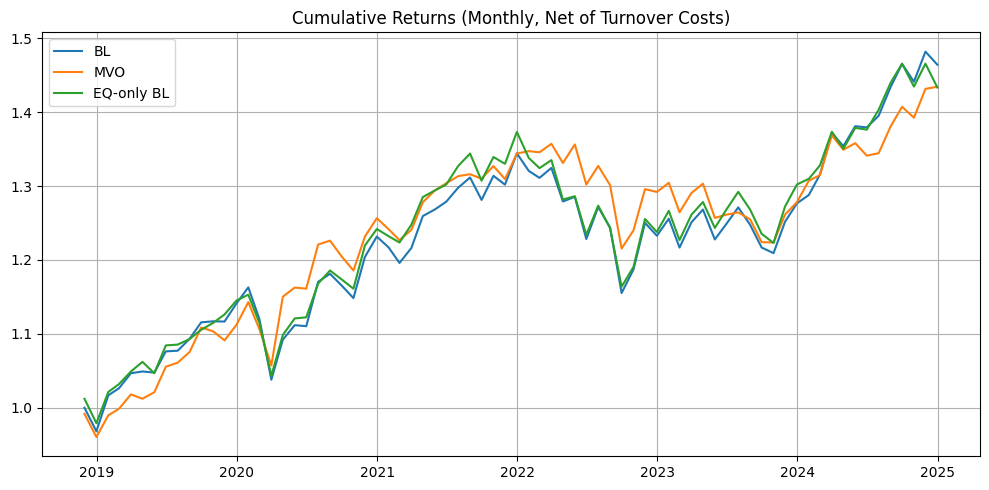

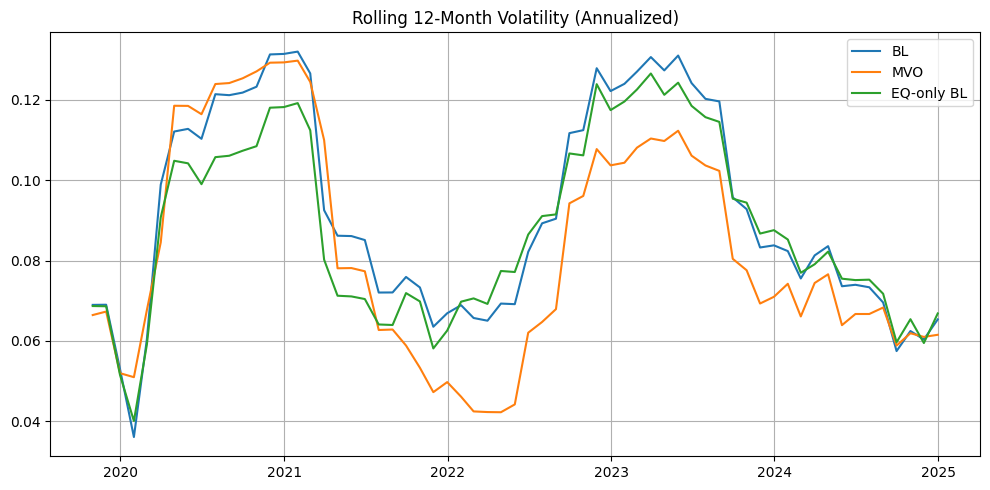

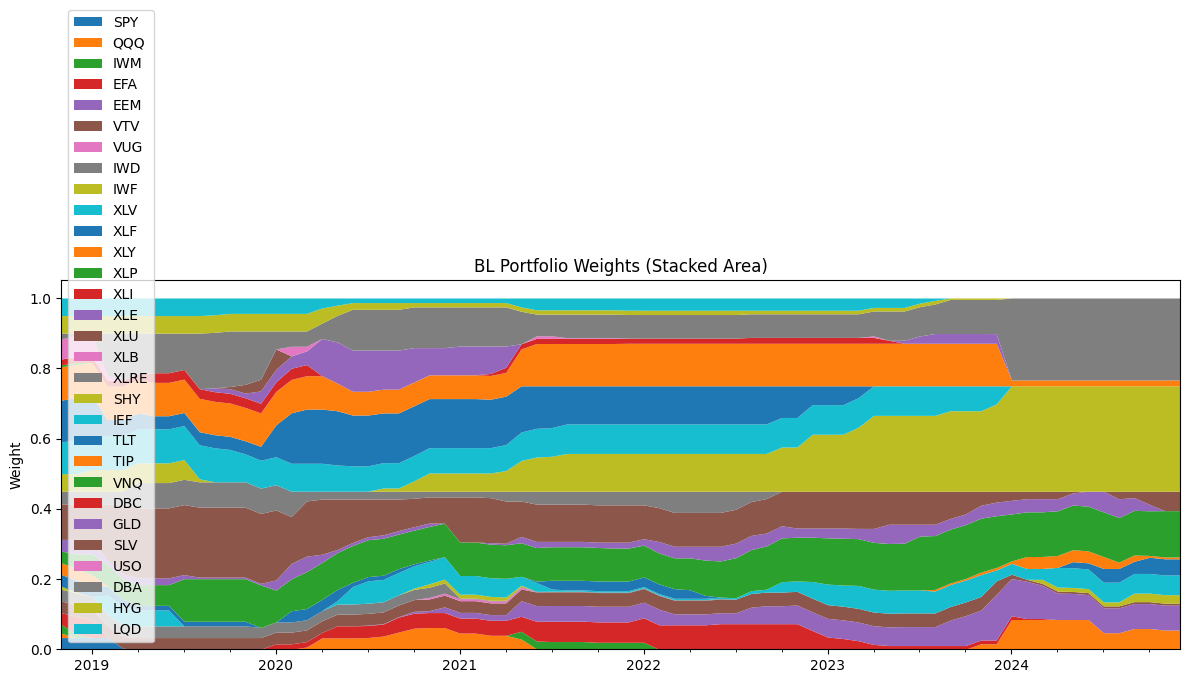

In [13]:
# Plots
cr = (1.0 + perf[["ret_BL","ret_MVO","ret_EQ"]]).cumprod()
plt.figure(figsize=(10,5)); plt.plot(cr.index, cr["ret_BL"], label="BL")
plt.plot(cr.index, cr["ret_MVO"], label="MVO"); plt.plot(cr.index, cr["ret_EQ"], label="EQ-only BL")
plt.title("Cumulative Returns (Monthly, Net of Turnover Costs)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

roll_vol = perf[["ret_BL","ret_MVO","ret_EQ"]].rolling(12).std() * np.sqrt(12)
plt.figure(figsize=(10,5)); plt.plot(roll_vol.index, roll_vol["ret_BL"], label="BL")
plt.plot(roll_vol.index, roll_vol["ret_MVO"], label="MVO"); plt.plot(roll_vol.index, roll_vol["ret_EQ"], label="EQ-only BL")
plt.title("Rolling 12-Month Volatility (Annualized)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,6)); w_bl.plot.area(ax=plt.gca(), linewidth=0)
plt.title("BL Portfolio Weights (Stacked Area)"); plt.ylabel("Weight"); plt.tight_layout(); plt.show()

### Results (2015–2024 BL backtest)

- **Process:** Monthly Black–Litterman on 30 ETFs, 36-month Ledoit–Wolf risk, momentum+carry views.  
  Views are **sector-neutralized within the coarse cap groups**, so single-member sleeves (TIP, LQD, HYG, VNQ) don’t get a direct view tilt.

**Out-of-sample (2023–2024)**  
- **BL:** 8.98% return, 7.34% vol, **Sharpe 1.22**, ~3.4% avg monthly turnover.  
- **MVO (unconstrained):** 5.36% return, 6.61% vol, **Sharpe 0.81**, ~27.6% turnover.  
- **EQ-only BL:** 7.61% return, 7.49% vol, **Sharpe 1.02**.  
- **Views help:** BL vs EQ-only Sharpe **+0.21**.

**Costs:** The turnover model implies ~**5 bps/yr** for BL vs **32 bps/yr** for MVO (first MVO trade charged vs benchmark).

**Caveats:**  
- The neutralization choice removes direct tilts in TIP/LQD/HYG/VNQ; that's intentional here
